In [107]:
# Import required libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

import torchvision
import numpy as np
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


In [108]:
# standardize random numbers for reproducibility
torch.manual_seed(0)


In [109]:
# input layer, a single hidden layer, and an output layer
# Define hyperparameters
input_size = 784  # 28x28 pixels
hidden_size = 128
num_classes = 10

batch_size = 100

In [110]:
img = torchvision.datasets.MNIST(root='../data', train=True, download=True)[0]

In [111]:
# Load MNIST dataset
transform = transforms.Compose(
    [
     transforms.ToTensor(),   # convert to pytorch tensor
     transforms.Normalize((0.1307,), (0.3081,))  # standardize the values with mean + std. Found before running code
    ]  
)


train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [112]:
array.mean()

tensor(0.0227)

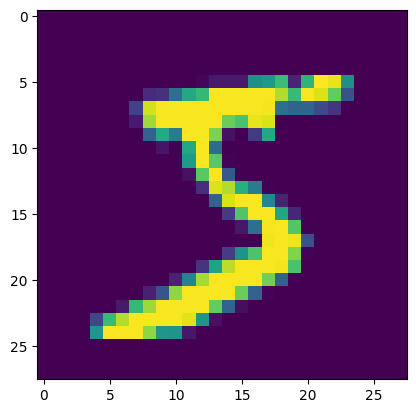

In [113]:
# transpose the array to (28, 28) format expected by Matplotlib
array = np.squeeze(np.transpose(train_dataset[0][0], (1, 2, 0)))

# plot the image using Matplotlib
plt.imshow(array)
plt.show()



In [114]:
next(iter(test_loader))[0].shape

torch.Size([100, 1, 28, 28])

In [115]:
# Define the neural network model
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Create the model
model = NeuralNet(input_size, hidden_size, num_classes)

In [116]:
# Some loss function options
cross_entropy_loss = nn.CrossEntropyLoss()
nll_loss = nn.NLLLoss()
mse_loss = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [117]:
input_size

784

In [118]:
# Function to train the model
def train_model(model, loss_function, train_loader, optimizer, num_epochs=10):
    # Put the model in training mode
    model.train()
    
    # Iterate over the number of epochs
    for epoch in range(num_epochs):
        # Initialize the running loss for this epoch to zero
        running_loss = 0.0
        
        # Iterate over each batch in the training loader
        for i, (images, labels) in enumerate(train_loader):
            
            # Reshape the images tensor to have size (batch_size, input_size)
            images = images.reshape(-1, input_size)
            # Forward pass: compute the outputs of the model given the input images
            outputs = model(images)
            # Compute the loss between the outputs and the true labels
            loss = loss_function(outputs, labels)
            # Backward pass: compute the gradients of the loss with respect to the model parameters
            optimizer.zero_grad()
            loss.backward()
            # Update the model parameters using the optimizer
            optimizer.step()
            
            # Add the current batch loss to the running loss for this epoch
            running_loss += loss.item()

        # Compute the average loss over all batches for this epoch and print it
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


In [119]:
# Function to evaluate the model
def evaluate_model(model, test_loader):
    # Put the model in evaluation mode
    model.eval()
    
    # Initialize empty lists to store true and predicted labels
    y_true, y_pred = [], []
    
    # Disable gradient computation since we're only evaluating the model
    with torch.no_grad():
        # Iterate over each batch in the test loader
        for images, labels in test_loader:
            # Reshape the images tensor to have size (batch_size, input_size)
            images = images.reshape(-1, input_size)
            
            # Forward pass: compute the outputs of the model given the input images
            outputs = model(images)
            
            # Find the predicted class for each image in the batch
            _, predicted = torch.max(outputs.data, 1)
            
            # Append the true and predicted labels for this batch to the lists
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())
    
    # Calculate evaluation metrics using the true and predicted labels
    accuracy, f1, precision, recall = evaluate_model_metrics(np.array(y_true), np.array(y_pred))
    
    # Return the evaluation metrics
    return accuracy, f1, precision, recall

# Function to calculate evaluation metrics
def evaluate_model_metrics(y_true, y_pred):
    # Compute the accuracy, F1 score, precision, and recall
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    # Return the evaluation metrics
    return accuracy, f1, precision, recall

# Define a dictionary of loss functions
loss_functions = {
    'CrossEntropyLoss': nn.CrossEntropyLoss(),
    'NLLLoss': nn.NLLLoss(),  # requires logsoftmax output (according to docs, so loss will be wrong without it!)
    'MultiMarginLoss': nn.MultiMarginLoss(),
    'KLDivLoss': nn.KLDivLoss()   # requires logsoftmax output (according to docs, so loss will be wrong without it!)
}

In [120]:
# Train and evaluate the model using different loss functions
for loss_name, loss_function in loss_functions.items():
    print(f'Training with {loss_name}:')
    
    # Initialize a new model and optimizer for each loss function
    model = NeuralNet(input_size, hidden_size, num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
    train_model(model, loss_function, train_loader, optimizer, num_epochs=5)

    # Evaluate the model
    accuracy, f1, precision, recall = evaluate_model(model, test_loader)
    print(f'Performance metrics for {loss_name}:')
    print(f'Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}\n')


Training with CrossEntropyLoss:
Epoch [1/5], Loss: 0.2866
Epoch [2/5], Loss: 0.1269
Epoch [3/5], Loss: 0.0869
Epoch [4/5], Loss: 0.0659
Epoch [5/5], Loss: 0.0511
Performance metrics for CrossEntropyLoss:
Accuracy: 0.9754, F1-score: 0.9753, Precision: 0.9756, Recall: 0.9752

Training with NLLLoss:
Epoch [1/5], Loss: -11701.7066
Epoch [2/5], Loss: -83472.9563
Epoch [3/5], Loss: -217246.9347
Epoch [4/5], Loss: -402067.4273
Epoch [5/5], Loss: -631296.8376


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Performance metrics for NLLLoss:
Accuracy: 0.1135, F1-score: 0.0204, Precision: 0.0114, Recall: 0.1000

Training with MultiMarginLoss:
Epoch [1/5], Loss: 0.0423
Epoch [2/5], Loss: 0.0156
Epoch [3/5], Loss: 0.0104
Epoch [4/5], Loss: 0.0079
Epoch [5/5], Loss: 0.0064
Performance metrics for MultiMarginLoss:
Accuracy: 0.9716, F1-score: 0.9714, Precision: 0.9722, Recall: 0.9710

Training with KLDivLoss:


/opt/homebrew/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


RuntimeError: kl_div: Integral inputs not supported.

# Making our code with with KL and NLL

In [130]:
# Function to train the model
def train_model(model, loss_function, train_loader, optimizer, num_epochs=10):
    # Put the model in training mode
    model.train()
    
    # Iterate over the number of epochs
    for epoch in range(num_epochs):
        # Initialize the running loss for this epoch to zero
        running_loss = 0.0
        
        # Iterate over each batch in the training loader
        for i, (images, labels) in enumerate(train_loader):
            
            # Reshape the images tensor to have size (batch_size, input_size)
            images = images.reshape(-1, input_size)
            # Forward pass: compute the outputs of the model given the input images
            outputs = model(images)

            #### NEW ####
            if 'KL' in str(loss_function) or 'NLL' in str(loss_function):
                outputs = F.log_softmax(outputs, dim=1)
            if 'KL' in str(loss_function):  # KL also need one hot 
                labels = one_hot_encode(labels, 10)
            #### NEW ####
            
            # Compute the loss between the outputs and the true labels
            loss = loss_function(outputs, labels)
            # Backward pass: compute the gradients of the loss with respect to the model parameters
            optimizer.zero_grad()
            loss.backward()
            # Update the model parameters using the optimizer
            optimizer.step()
            
            # Add the current batch loss to the running loss for this epoch
            running_loss += loss.item()

        # Compute the average loss over all batches for this epoch and print it
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


In [131]:
def one_hot_encode(labels, num_classes):
    # Create a tensor of zeros with shape [len(labels), num_classes]
    one_hot = torch.zeros(len(labels), num_classes)
    
    # Use scatter_ to assign 1s to the correct class indices
    one_hot.scatter_(1, labels.unsqueeze(1), 1)
    
    return one_hot


In [133]:

# Define a dictionary of loss functions
loss_functions = {
    'NLLLoss': nn.NLLLoss(),  
    'KLDivLoss': nn.KLDivLoss(reduction='batchmean'),  # to avoid deprecation warning, I'm setting reduction to batchmean
    'CrossEntropyLoss': nn.CrossEntropyLoss()
}
# Train and evaluate the model using different loss functions
for loss_name, loss_function in loss_functions.items():
    print(f'Training with {loss_name}:')
    
    # Initialize a new model and optimizer for each loss function
    model = NeuralNet(input_size, hidden_size, num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
    train_model(model, loss_function, train_loader, optimizer, num_epochs=5)

    # Evaluate the model
    accuracy, f1, precision, recall = evaluate_model(model, test_loader)
    print(f'Performance metrics for {loss_name}:')
    print(f'Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}\n')


Training with NLLLoss:
Epoch [1/5], Loss: 0.2944
Epoch [2/5], Loss: 0.1269
Epoch [3/5], Loss: 0.0859
Epoch [4/5], Loss: 0.0655
Epoch [5/5], Loss: 0.0511
Performance metrics for NLLLoss:
Accuracy: 0.9755, F1-score: 0.9754, Precision: 0.9755, Recall: 0.9753

Training with KLDivLoss:
Epoch [1/5], Loss: 0.2850
Epoch [2/5], Loss: 0.1252
Epoch [3/5], Loss: 0.0850
Epoch [4/5], Loss: 0.0645
Epoch [5/5], Loss: 0.0508
Performance metrics for KLDivLoss:
Accuracy: 0.9765, F1-score: 0.9763, Precision: 0.9762, Recall: 0.9764

Training with CrossEntropyLoss:
Epoch [1/5], Loss: 0.2846
Epoch [2/5], Loss: 0.1241
Epoch [3/5], Loss: 0.0854
Epoch [4/5], Loss: 0.0650
Epoch [5/5], Loss: 0.0518
Performance metrics for CrossEntropyLoss:
Accuracy: 0.9772, F1-score: 0.9770, Precision: 0.9770, Recall: 0.9770



/opt/homebrew/lib/python3.11/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


<Axes: >

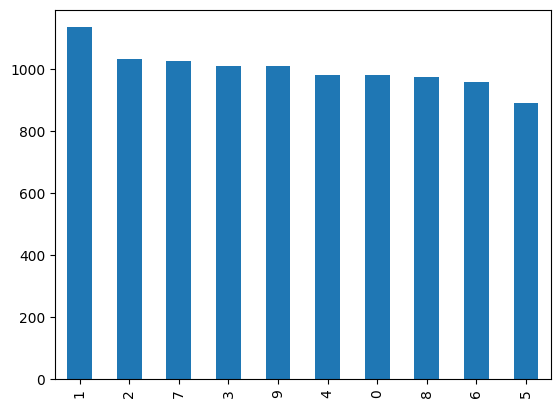

In [145]:
import pandas as pd

# KL is better for imbalanced data, which this isn't so much
pd.Series(test_dataset.train_labels).value_counts().plot(kind='bar')